# Transformer - Embrace Angels

## Setup

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.layers import Layer, Add, Embedding, GlobalAveragePooling1D, Concatenate, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, medfilt
import time

np.random.seed(42)
tf.random.set_seed(42)
save_dir = 'progressive_hug_results'
os.makedirs(save_dir, exist_ok=True)

## Import data

In [ ]:
# def load_hug_sequences(folder_path='Desktop/dance_data'):
#     csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

#     if not csv_files:
#         raise ValueError(f"No CSV files found in {folder_path}")

#     print(f"Found {len(csv_files)} hug sequence files")
#     hug_sequences = []
#     for file in csv_files:
#         try:
#             df = pd.read_csv(file)
#             print(f"Loaded {os.path.basename(file)}: {df.shape[0]} timestamps, {df.shape[1]} features")
#             hug_sequences.append(df)

#         except Exception as e:
#             print(f"Error loading {file}: {str(e)}")

#     print(f"\nSuccessfully loaded {len(hug_sequences)} hug sequences")
#     return hug_sequences

# hug_sequences = load_hug_sequences()

In [ ]:
def load_hug_sequences(folder_path='Desktop/public_data'):
    import os
    import glob
    import pandas as pd

    # Use os.walk to recursively find all CSV files
    csv_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))

    if not csv_files:
        raise ValueError(f"No CSV files found in {folder_path} or its subfolders")

    print(f"Found {len(csv_files)} CSV files across all folders")

    # Create a list to store all sequences
    hug_sequences = []

    # Loop through each CSV file and load it as a separate sequence
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            print(f"Loaded {os.path.basename(file)}: {df.shape[0]} timestamps, {df.shape[1]} features")
            hug_sequences.append(df)

        except Exception as e:
            print(f"Error loading {file}: {str(e)}")

    print(f"\nSuccessfully loaded {len(hug_sequences)} sequences")
    return hug_sequences

# Usage
hug_sequences = load_hug_sequences()

Found 50 CSV files across all folders
Loaded public_simon_6.csv: 1574 timestamps, 14 features
Loaded public_kiean_7.csv: 659 timestamps, 14 features
Loaded public_kiean_13.csv: 1175 timestamps, 14 features
Loaded public_kiean_12.csv: 1117 timestamps, 14 features
Loaded public_kieran_16.csv: 778 timestamps, 14 features
Loaded public_kiean_6.csv: 784 timestamps, 14 features
Loaded public_simon_7.csv: 742 timestamps, 14 features
Loaded public_simon_5.csv: 1488 timestamps, 14 features
Loaded public_kiean_4.csv: 520 timestamps, 14 features
Loaded public_kiean_10.csv: 701 timestamps, 14 features
Loaded public_kiean_11.csv: 914 timestamps, 14 features
Loaded public_kiean_5.csv: 335 timestamps, 14 features
Loaded public_simon_4.csv: 1560 timestamps, 14 features
Loaded public_kiean_1.csv: 605 timestamps, 14 features
Loaded public_simon_18.csv: 1662 timestamps, 14 features
Loaded public_kiean_15.csv: 711 timestamps, 14 features
Loaded public_kiean_14.csv: 725 timestamps, 14 features
Loaded publi

In [ ]:
# def preprocess_sequences(hug_sequences, window_size, stride=50):
#     # Extract features (positions and velocities)
#     feature_names = [f'Position{i}' for i in range(1, 8)] + [f'Velocity{i}' for i in range(1, 8)]
#     scaler = RobustScaler()

#     all_sequences = []
#     full_scaled_sequences = []

#     for hug_df in hug_sequences:
#         # Extract features
#         features = hug_df[feature_names].values

#         # Check for NaN values
#         if np.isnan(features).any():
#             print(f"Warning: NaN values found in sequence, filling with zeros")
#             features = np.nan_to_num(features)

#         # Fit scaler on the first sequence, then just transform
#         if len(full_scaled_sequences) == 0:
#             scaled_features = scaler.fit_transform(features)
#         else:
#             scaled_features = scaler.transform(features)

#         # Clip extreme values after scaling
#         scaled_features = np.clip(scaled_features, -3.0, 3.0)

#         # Add full sequence for reference
#         full_scaled_sequences.append(scaled_features)

#         # Create overlapping windows
#         for i in range(0, len(scaled_features) - window_size + 1, stride):
#             subsequence = scaled_features[i:i+window_size]
#             if len(subsequence) == window_size:
#                 all_sequences.append(subsequence)

#     # Convert to numpy array
#     X_train = np.array(all_sequences)
#     print(f"Created {X_train.shape[0]} training sequences of shape {X_train.shape[1:]}")

#     return X_train, scaler, full_scaled_sequences

# window_size = 400

# print("\nPreprocessing sequences...")
# X_train, scaler, full_sequences = preprocess_sequences(
# hug_sequences,
# window_size=window_size,
# stride=50
# )

# X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

In [ ]:
def preprocess_sequences(hug_sequences, window_size, stride=50):
    # Extract features (positions and velocities)
    # feature_names = [f'Position{i}' for i in range(1, 8)] + [f'Velocity{i}' for i in range(1, 8)]
    feature_names = [f'act_pos{i}' for i in range(1, 8)] + [f'vel{i}' for i in range(1, 8)]
    scaler = RobustScaler()

    all_sequences = []
    full_scaled_sequences = []

    # First pass: fit scaler on original data
    all_original_features = []
    for hug_df in hug_sequences:
        features = hug_df[feature_names].values
        if np.isnan(features).any():
            features = np.nan_to_num(features)
        all_original_features.append(features)

    # Combine all original features and fit scaler
    combined_features = np.vstack(all_original_features)
    scaler.fit(combined_features)

    # Second pass: create windows for original and augmented data
    for hug_df in hug_sequences:
        # Process original sequence
        features = hug_df[feature_names].values
        if np.isnan(features).any():
            features = np.nan_to_num(features)

        # Scale original features
        scaled_features = scaler.transform(features)
        scaled_features = np.clip(scaled_features, -3.0, 3.0)
        full_scaled_sequences.append(scaled_features)

        # Create windows from original
        print(f"Creating windows from original sequence: {len(features)} frames")
        window_count = 0
        for i in range(0, len(scaled_features) - window_size + 1, stride):
            subsequence = scaled_features[i:i+window_size]
            if len(subsequence) == window_size:
                all_sequences.append(subsequence)
                window_count += 1
        print(f"Added {window_count} windows from original sequence")

        # Process and add noise-augmented versions separately
        for noise_level in [0.01, 0.02]:
            # Create noisy version
            noisy_features = features + np.random.normal(0, noise_level, features.shape)

            # Scale noisy features
            scaled_noisy = scaler.transform(noisy_features)
            scaled_noisy = np.clip(scaled_noisy, -3.0, 3.0)

            # Add to full sequences
            full_scaled_sequences.append(scaled_noisy)

            # Create windows from noisy version
            noise_window_count = 0
            for i in range(0, len(scaled_noisy) - window_size + 1, stride):
                subsequence = scaled_noisy[i:i+window_size]
                if len(subsequence) == window_size:
                    all_sequences.append(subsequence)
                    noise_window_count += 1
            print(f"Added {noise_window_count} windows from noisy sequence (level={noise_level})")

    X_train = np.array(all_sequences)
    print(f"Created {X_train.shape[0]} total training sequences of shape {X_train.shape[1:]}")

    return X_train, scaler, full_scaled_sequences



print("\nPreprocessing sequences...")
X_train, scaler, full_sequences = preprocess_sequences(
hug_sequences,
window_size=400,
stride=50
)

X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)


Preprocessing sequences...
Creating windows from original sequence: 1574 frames
Added 24 windows from original sequence
Added 24 windows from noisy sequence (level=0.01)
Added 24 windows from noisy sequence (level=0.02)
Creating windows from original sequence: 659 frames
Added 6 windows from original sequence
Added 6 windows from noisy sequence (level=0.01)
Added 6 windows from noisy sequence (level=0.02)
Creating windows from original sequence: 1175 frames
Added 16 windows from original sequence
Added 16 windows from noisy sequence (level=0.01)
Added 16 windows from noisy sequence (level=0.02)
Creating windows from original sequence: 1117 frames
Added 15 windows from original sequence
Added 15 windows from noisy sequence (level=0.01)
Added 15 windows from noisy sequence (level=0.02)
Creating windows from original sequence: 778 frames
Added 8 windows from original sequence
Added 8 windows from noisy sequence (level=0.01)
Added 8 windows from noisy sequence (level=0.02)
Creating window

## Create transformer

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()

        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            attention_axes=(1,2) #was (1,2)
        )

        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu"),
            Dropout(rate),
            Dense(embed_dim, kernel_initializer="glorot_uniform"),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-5)
        self.layernorm2 = LayerNormalization(epsilon=1e-5)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.add1 = Add()
        self.add2 = Add()

    def call(self, inputs, training=None):
        normalized = self.layernorm1(inputs)

        # Basic attention without explicit mask
        attn_output = self.att(normalized, normalized)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add1([inputs, attn_output])

        normalized2 = self.layernorm2(out1)
        ffn_output = self.ffn(normalized2)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.add2([out1, ffn_output])


In [ ]:
class MaskCreationLayer(Layer):
    def __init__(self, **kwargs):
        super(MaskCreationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Create a mask for non-zero values
        return tf.reduce_any(tf.not_equal(inputs, 0), axis=-1)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class MaskedGlobalAveragePooling(Layer):
    def __init__(self, **kwargs):
        super(MaskedGlobalAveragePooling, self).__init__(**kwargs)

    def call(self, inputs):
        x, mask = inputs
        # Expand mask for broadcasting
        mask = tf.expand_dims(tf.cast(mask, x.dtype), -1)
        # Apply mask to zero out padded regions
        masked_x = x * mask
        # Calculate sequence lengths for averaging
        sequence_lengths = tf.reduce_sum(mask, axis=1)
        # Avoid division by zero
        sequence_lengths = tf.maximum(sequence_lengths, 1.0)
        # Sum and normalize
        return tf.reduce_sum(masked_x, axis=1) / sequence_lengths

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][2])

In [ ]:
def build_progressive_transformer(
    max_sequence_length,
    feature_dim,
    embed_dim=128, #was 64
    num_heads=6, #was 4
    ff_dim=256, #was 128
    num_transformer_blocks=5, #was 3
    mlp_units=[128, 64],
    dropout=0.1,
    window_size=400
):

    # Input sequence with variable length (None)
    inputs = Input(shape=(None, feature_dim))

    # Create a mask from the inputs using a custom layer
    mask = MaskCreationLayer()(inputs)

    # Initial embedding and normalization
    x = LayerNormalization(epsilon=1e-5)(inputs)
    x = Dense(embed_dim, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(x)

    # Add positional embedding
    positions = tf.keras.layers.Lambda(
        lambda shape: tf.range(shape[1]),
        output_shape=(None,)
    )(tf.keras.layers.Lambda(lambda x: tf.shape(x))(x))

    position_embedding = Embedding(
        input_dim=max_sequence_length,
        output_dim=embed_dim,
        embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    )(positions)

    # Apply the embeddings
    x = Add()([x, position_embedding])

    # Apply dropout
    x = Dropout(dropout)(x)

    # Transformer blocks - manually creating attention masks in each block
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x)

    # Final normalization
    x = LayerNormalization(epsilon=1e-5)(x)

    # Global pooling with masking using custom layer
    global_features = MaskedGlobalAveragePooling()([x, mask])

    # MLP head
    for dim in mlp_units:
        global_features = Dense(
            dim,
            activation="selu",
            kernel_initializer="lecun_normal"
        )(global_features)
        global_features = Dropout(dropout)(global_features)

    # Output layer for next window prediction
    # predict a window of the same size as our training window
    outputs = Dense(
        window_size * feature_dim,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
    )(global_features)
    outputs = tf.keras.layers.Reshape((window_size, feature_dim))(outputs)

    return Model(inputs, outputs)

##Generate movement function

In [ ]:
def generate_with_progressive_conditioning(
    model,
    seed_sequence,
    scaler,
    target_length,
    window_size,
    feature_dim,
    step_size=80,           # Larger step size to reduce repetition
    transition_frames=10,   # Moderate transition frames
    noise_level=0.02        # Noise to break repetitive patterns
):

    # Start with seed sequence
    generated_sequence = seed_sequence.copy()
    generated_frames = generated_sequence.reshape(-1, feature_dim)

    # Keep track of context sizes to progressively increase
    context_size = min(len(generated_frames), window_size // 2)

    # Keep a longer history for better global structure
    history_buffer = generated_frames.copy()

    # Generate the sequence step by step
    print(f"Starting generation with initial context of {context_size} frames...")
    while len(generated_frames) < target_length:
        # Get the current context from the history buffer
        if len(history_buffer) <= context_size:
            # If don't have enough frames yet, use all we have
            current_context = history_buffer
        else:
            # Use the last context_size frames from history buffer
            current_context = history_buffer[-context_size:]

        # Reshape for model input (batch size of 1)
        model_input = current_context.reshape(1, -1, feature_dim)

        # Generate the next window
        next_window = model.predict(model_input, verbose=0)[0]

        # Add small random noise to break repetitive patterns
        noise = np.random.normal(0, noise_level, next_window.shape)
        next_window = next_window + noise

        # Clip predicted values
        next_window = np.clip(next_window, -3.0, 3.0)

        # Keep only step_size frames from the prediction
        frames_to_keep = min(step_size, target_length - len(generated_frames))
        if frames_to_keep <= 0:
            break

        frames_to_append = next_window[:frames_to_keep]

        # Apply smoothing between the last frame of current sequence and first frame of new prediction
        if len(generated_frames) > 0:
            # Get the last frame of the current sequence
            last_frame = generated_frames[-1:].copy()
            # Get the first frame of the new prediction
            first_new_frame = frames_to_append[0:1].copy()

            # Create a smooth transition
            transition_frames_count = min(transition_frames, len(frames_to_append))
            transition = np.zeros((transition_frames_count, feature_dim))

            for i in range(transition_frames_count):
                # Smooth cubic interpolation weight
                t = (i + 1) / (transition_frames_count + 1)
                # Using cubic interpolation: t² * (3-2t)
                weight = t * t * (3 - 2 * t)
                transition[i] = last_frame * (1 - weight) + first_new_frame * weight

            # Replace first few frames with the transition
            frames_to_append[:transition_frames_count] = transition

        # Append to the generated sequence
        generated_frames = np.vstack([generated_frames, frames_to_append])

        # Add to history buffer, but randomly drop some older frames to prevent pattern lock
        if len(history_buffer) > window_size * 1.5:
            # Keep recent frames and a selection of older ones
            recent_keep = int(window_size * 0.7)
            older_frames = history_buffer[:-recent_keep]
            # Keep about half of the older frames randomly
            keep_indices = np.random.choice(
                len(older_frames),
                size=min(len(older_frames) // 2, window_size),
                replace=False
            )
            keep_indices = np.sort(keep_indices)
            history_buffer = np.vstack([older_frames[keep_indices], history_buffer[-recent_keep:]])

        # Add new frames to history buffer
        history_buffer = np.vstack([history_buffer, frames_to_append])

        # Progressively increase context size
        if context_size < window_size:
            context_size = min(context_size + step_size // 4, window_size)

        print(f"Generated {len(generated_frames)}/{target_length} frames, context size: {context_size}", end="\r")

    print(f"\nGeneration complete. Final sequence shape: {generated_frames.shape}")

    # Apply a multi-stage smoothing process to remove oscillations while preserving trends

    # 1. First pass with a small window to preserve general shape
    smoothed_frames = np.zeros_like(generated_frames)
    small_window = min(21, len(generated_frames) // 5)
    small_window = small_window if small_window % 2 == 1 else small_window - 1

    if small_window >= 5:
        for i in range(generated_frames.shape[1]):
            try:
                smoothed_frames[:, i] = savgol_filter(generated_frames[:, i], small_window, 3)
            except Exception as e:
                print(f"Warning: First smoothing pass failed: {e}")
                smoothed_frames[:, i] = generated_frames[:, i]
    else:
        smoothed_frames = generated_frames.copy()

    # 2. Trend extraction with a larger window
    trend_component = np.zeros_like(smoothed_frames)
    large_window = min(101, len(generated_frames) // 3)
    large_window = large_window if large_window % 2 == 1 else large_window - 1

    if large_window >= 11:
        for i in range(smoothed_frames.shape[1]):
            try:
                trend_component[:, i] = savgol_filter(smoothed_frames[:, i], large_window, 3)
            except Exception as e:
                print(f"Warning: Trend extraction failed: {e}")
                trend_component[:, i] = smoothed_frames[:, i]

        # 3. Blend trend (70%) with detail (30%) to preserve some natural variation
        final_smoothed = 0.7 * trend_component + 0.3 * smoothed_frames
    else:
        final_smoothed = smoothed_frames

    # 4. Apply median filter to remove remaining spikes
    from scipy.signal import medfilt
    for i in range(final_smoothed.shape[1]):
        try:
            final_smoothed[:, i] = medfilt(final_smoothed[:, i], min(11, len(final_smoothed) // 10))
        except Exception as e:
            print(f"Warning: Median filtering failed: {e}")

    # Rescale to original range
    generated_sequence_rescaled = scaler.inverse_transform(final_smoothed)

    return generated_sequence_rescaled

## Train model

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')


Maximum sequence length in dataset: 1671

Progressive Transformer Model Summary:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None, 14)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 14)  │         28 │ input_layer_6[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, None, 128) │      1,920 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (3)               │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (3, None)         │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (3, None, 128)    │    213,888 │ lambda_2[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (3, None, 128)    │          0 │ dense_15[0][0],   │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (3, None, 128)    │          0 │ add_11[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_5 │ (3, None, 128)    │    165,376 │ dropout_24[0][0]  │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_6 │ (3, None, 128)    │    165,376 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_7 │ (3, None, 128)    │    165,376 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_8 │ (3, None, 128)    │    165,376 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_9 │ (3, None, 128)    │    165,376 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, None, 14)  │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (3, None, 128)    │        256 │ transformer_bloc… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_creation_laye… │ (None, None)      │          0 │ cast_1[0][0]      │
│ (MaskCreationLayer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_global_aver… │ (3, 128)          │          0 │ layer_normalizat… │
│ (MaskedGlobalAvera… │                   │            │ mask_creation_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (3, 256)          │     33,024 │ masked_global_av… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,481,148 (5.65 MB)

 Trainable params: 1,481,148 (5.65 MB)

 Non-trainable params: 0 (0.00 B)


Starting initial training to check stability...
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 3.1921 - mae: 1.0775 - val_loss: 3.0020 - val_mae: 0.9902
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 942ms/step - loss: 3.0165 - mae: 0.9931 - val_loss: 2.9351 - val_mae: 0.9472
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 953ms/step - loss: 2.9544 - mae: 0.9594 - val_loss: 2.9102 - val_mae: 0.9282
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 926ms/step - loss: 2.9298 - mae: 0.9478 - val_loss: 2.8996 - val_mae: 0.9247
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 944ms/step - loss: 2.9145 - mae: 0.9413 - val_loss: 2.8897 - val_mae: 0.9157
Initial training successful! Continuing with full training...
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 942ms/step - loss: 2.8985 - mae: 0.9336 - val_loss: 2.8857 - val_mae: 0.9119
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 934ms/step - loss: 2.8927 - mae: 0.9328 - val_loss: 2.8825 - val_mae: 0.9119
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 920ms/step - loss: 

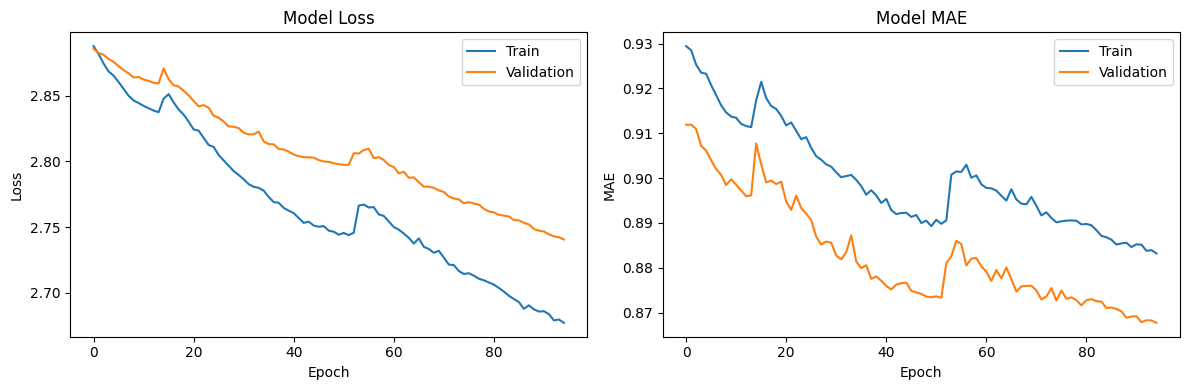

In [ ]:
feature_dim = X_train.shape[2]  # Number of features

# Find the longest sequence in the dataset
max_sequence_length = max([len(seq) for seq in full_sequences])
print(f"Maximum sequence length in dataset: {max_sequence_length}")

embed_dim = 128 #was 64
num_heads = 8 #was 4
ff_dim = 384 #was 128
num_transformer_blocks = 5 #was 3
mlp_units = [256, 128, 64] #was 128, 64
dropout = 0.2

model = build_progressive_transformer(
max_sequence_length=max_sequence_length,
feature_dim=feature_dim,
embed_dim=embed_dim,
num_heads=num_heads,
ff_dim=ff_dim,
num_transformer_blocks=num_transformer_blocks,
mlp_units=mlp_units,
dropout=dropout
)

# optimizer = Adam(learning_rate=0.0005)



#  custom learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=500,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.1
)
optimizer = Adam(learning_rate=lr_schedule)





optimizer.clipnorm = 1.0  # Add gradient clipping



def custom_motion_loss(y_true, y_pred):
    # Position error (MSE)
    position_mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # Velocity smoothness (penalize sudden changes)
    true_vel = y_true[:, 1:] - y_true[:, :-1]
    pred_vel = y_pred[:, 1:] - y_pred[:, :-1]
    velocity_smoothness = tf.reduce_mean(tf.square(true_vel - pred_vel))

    # Combined loss with weighting
    return position_mse + 0.5 * velocity_smoothness




model.compile(
optimizer=optimizer,
# loss='mse',
loss = custom_motion_loss,
metrics=['mae']
)

print("\nProgressive Transformer Model Summary:")
model.summary()

callbacks = [
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
),
tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir, 'progressive_model.keras'),
    monitor='val_loss',
    save_best_only=True
),
# tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=0.00001
# ),
tf.keras.callbacks.TerminateOnNaN()
]

# Initial training with a smaller batch size for stability
print("\nStarting initial training to check stability...")
with tf.device('/GPU:0'):
    initial_history = model.fit(
    X_train, X_train,  # Autoencoder style training
    validation_data=(X_val, X_val),
    epochs=5,
    batch_size=64,
    callbacks=[tf.keras.callbacks.TerminateOnNaN()],
    verbose=1
    )

# Check if initial training was successful
if not np.isnan(initial_history.history['loss'][-1]):
  print("Initial training successful! Continuing with full training...")

# Continue with full training
history = model.fit(
    X_train, X_train,  # Autoencoder style training
    validation_data=(X_val, X_val),
    initial_epoch=5,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

model.save(os.path.join(save_dir, 'progressive_model.keras'))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'training_history.png'))



## Generate new sequence


Generating a complete hug sequence with progressive conditioning...
Target sequence length: 973 (based on average length of training sequences)
Starting generation with initial context of 200 frames...
Generated 973/973 frames, context size: 360
Generation complete. Final sequence shape: (973, 14)

Progressive conditioning hug sequence generation successful!
Generated sequence saved to progressive_hug_results/generated_hug_sequence.csv


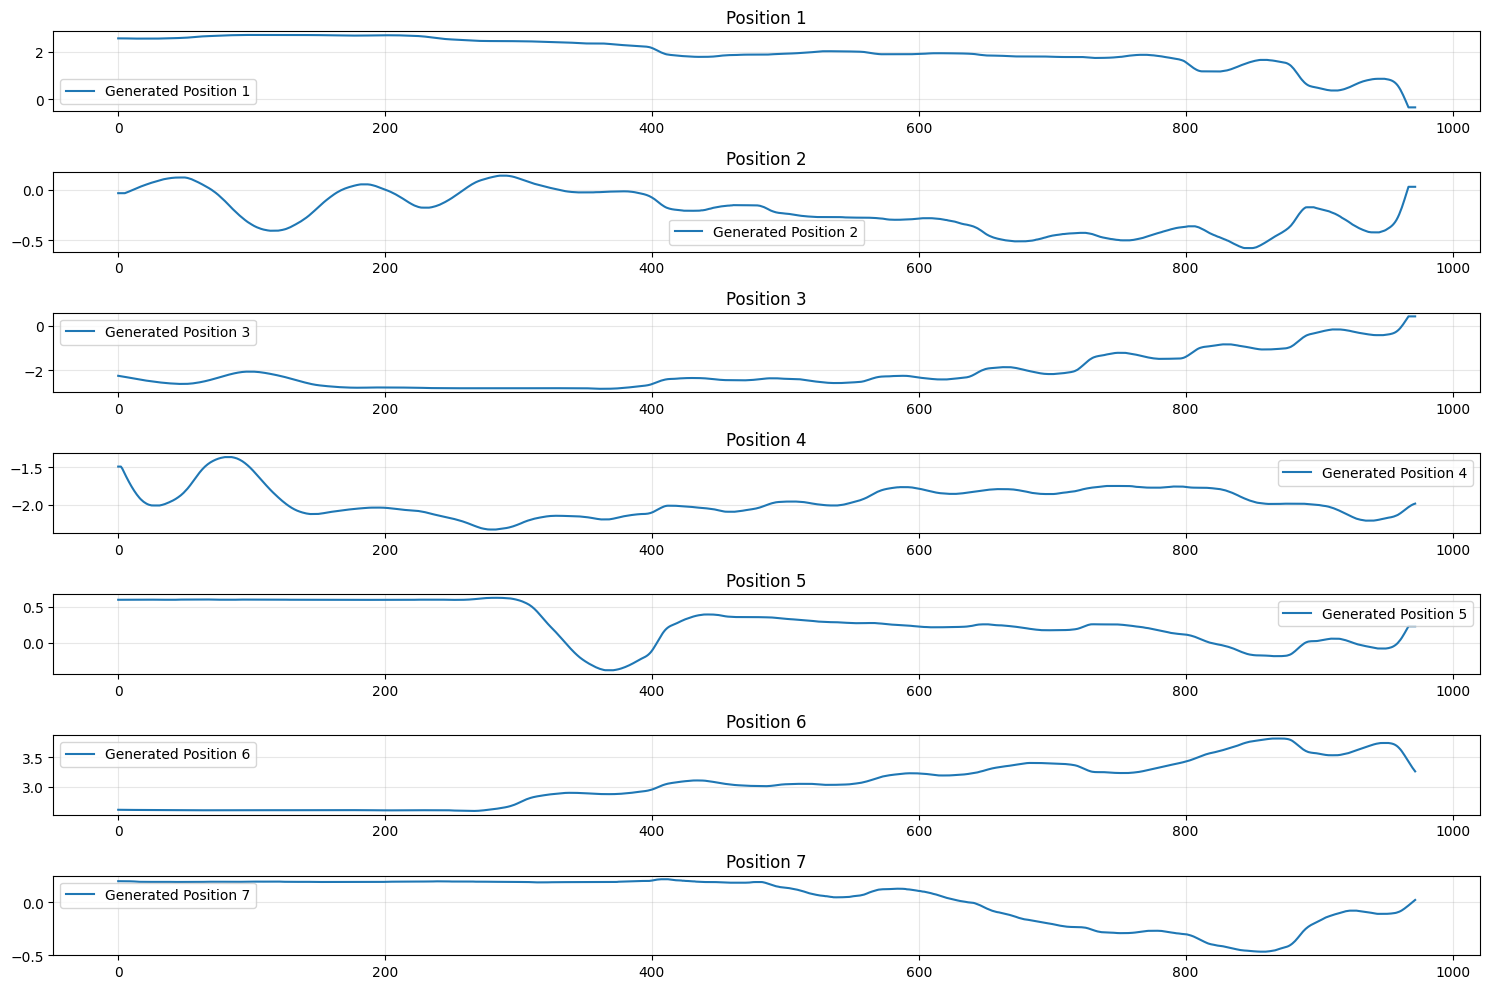

In [ ]:
# Generate a complete hug sequence
print("\nGenerating a complete hug sequence with progressive conditioning...")
seed_idx = np.random.randint(0, len(X_val))
seed_idx = 0
seed_sequence = X_val[seed_idx:seed_idx+400][0]  # Get the actual sequence

# Get typical sequence length from training data
avg_seq_length = np.mean([len(seq) for seq in full_sequences])
target_length = int(avg_seq_length)
print(f"Target sequence length: {target_length} (based on average length of training sequences)")

# Generate sequence using progressive conditioning
generated_sequence = generate_with_progressive_conditioning(
    model,
    seed_sequence,
    scaler,
    target_length,
    400,
    feature_dim,
    step_size=80,           # Larger step size to reduce repetition
    transition_frames=10,   # Moderate transition frames
    noise_level=0.02        # Small noise to break repetitive patterns
)

plt.figure(figsize=(15, 10))

# Plot positions (first 7 features are positions)
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(generated_sequence[:, i], label=f'Generated Position {i+1}')
    plt.title(f'Position {i+1}')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'progressive_hug_sequence.png'))

pd.DataFrame(
    generated_sequence,
    columns=[f'Position{i}' for i in range(1, 8)] + [f'Velocity{i}' for i in range(1, 8)]
).to_csv(os.path.join(save_dir, 'generated_hug_sequence.csv'), index=False)

print("\nProgressive conditioning hug sequence generation successful!")
print(f"Generated sequence saved to {os.path.join(save_dir, 'generated_hug_sequence.csv')}")


# Save model

In [ ]:
import json
def save_my_model(model, save_dir):
    """Custom save function that handles all components of your model"""
    os.makedirs(save_dir, exist_ok=True)

    # Save weights
    model.save_weights(os.path.join(save_dir, 'weights.weights.h5'))

    # Save model parameters (not the full architecture)
    params = {
        'embed_dim': 128,
        'num_heads': 8,
        'ff_dim': 384,
        'num_transformer_blocks': 5,
        'mlp_units': [256, 128, 64],
        'dropout': 0.2,
        'window_size': 400,
        'max_sequence_length': max_sequence_length,
        'feature_dim': feature_dim
    }
    with open(os.path.join(save_dir, 'params.json'), 'w') as f:
        json.dump(params, f)

    print(f"Model saved to {save_dir}")

save_my_model(model, 'progressive_hug_results')


Model saved to progressive_hug_results


In [ ]:
from joblib import dump, load

save_dir = 'progressive_hug_results'
os.makedirs(save_dir, exist_ok=True)
dump(scaler, os.path.join(save_dir, 'scaler.joblib'))

['progressive_hug_results/scaler.joblib']

# Simulator

In [1]:
!mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement.py /Users/pszkw/progressive_hug_results/generated_hug_sequence.csv

Starting playback...


In [ ]:
  !mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement.py /Users/pszkw/progressive_hug_results/dance_movement.csv

Starting playback...


In [ ]:
!mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement.py /Users/pszkw/progressive_hug_results/public_movement.csv

Starting playback...


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.7 MB/s eta 0:00:00


###  Comparison (no PD)

In [ ]:
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display # Keep display for video output
from base64 import b64encode
import tempfile
import os
import time


def run_simulation_and_capture_frames_sequential(generated_sequence, temp_dir, fps=20, sample_rate=1):
    joint_data = generated_sequence[:, :7]
    print(f"Joint position data shape: {joint_data.shape}")

    sampled_positions = joint_data[::sample_rate]
    num_frames_to_process = len(sampled_positions)
    print(f"Total frames: {len(joint_data)}, Sampled frames to process: {num_frames_to_process}")

    try:
        physics_client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        print("PyBullet connected in DIRECT mode.")
    except Exception as e:
        print(f"Error connecting to PyBullet: {e}")
        return 0 # Return 0 successful frames

    try:
        plane_id = p.loadURDF("plane.urdf")
        robot_path = os.path.join(pybullet_data.getDataPath(), "franka_panda/panda.urdf")
        if not os.path.exists(robot_path):
             raise FileNotFoundError(f"Panda URDF not found at expected path: {robot_path}")
        robot_id = p.loadURDF(robot_path, [0, 0, 0], useFixedBase=True)
        print("URDFs loaded.")
    except Exception as e:
        print(f"Error loading URDFs: {e}")
        if p.isConnected():
            p.disconnect()
        return 0

    width, height = 640, 480
    view_matrix = p.computeViewMatrix(
        cameraEyePosition=[1.2, -1.0, 1.0],
        cameraTargetPosition=[0, 0, 0.5],
        cameraUpVector=[0, 0, 1]
    )
    projection_matrix = p.computeProjectionMatrixFOV(
        fov=60,
        aspect=width / height,
        nearVal=0.1,
        farVal=100.0
    )

    successful_frames = 0
    start_time = time.time()
    print("Starting sequential frame processing...")

    for frame_idx, joint_values in enumerate(sampled_positions):
        try:
            # Set joint positions directly using resetJointState
            # This effectively teleports the robot to the state for each frame
            for j in range(7):
                 # Use correct joint indices (0-6 for Franka in this URDF)
                 p.resetJointState(robot_id, j, joint_values[j])

            p.stepSimulation()

            # Capture frame
            img_arr = p.getCameraImage(
                width=width,
                height=height,
                viewMatrix=view_matrix,
                projectionMatrix=projection_matrix,
                renderer=p.ER_BULLET_HARDWARE_OPENGL
            )
            rgb = img_arr[2]
            rgb_array = np.reshape(rgb, (height, width, 4))[:, :, :3]

            # Save frame
            frame_path = os.path.join(temp_dir, f"frame_{frame_idx:04d}.png")
            plt.imsave(frame_path, rgb_array)
            successful_frames += 1

            # Print progress
            if frame_idx % 50 == 0 or frame_idx == num_frames_to_process - 1:
                elapsed = time.time() - start_time
                print(f"Processed frame {frame_idx+1}/{num_frames_to_process} ({successful_frames} saved) [{elapsed:.2f}s]", end="\r")

        except Exception as e:
            print(f"\nError processing frame {frame_idx}: {e}")


    print(f"\nSequential frame processing complete! Successfully captured {successful_frames}/{num_frames_to_process} frames.")
    end_time = time.time()
    print(f"Total processing time: {end_time - start_time:.2f} seconds")

    if p.isConnected():
        p.disconnect()
        print("PyBullet disconnected.")

    return successful_frames


def create_video(temp_dir, output_video_name="franka_simulation_old_method.mp4", fps=20):
    """Create a video from the generated frames using FFmpeg"""
    print(f"Creating video '{output_video_name}' at {fps} FPS...")
    output_dir = "Desktop"
    if not os.path.exists(output_dir):
        try:
            os.makedirs(output_dir)
        except OSError as e:
            print(f"Error creating output directory '{output_dir}': {e}. Saving to current dir.")
            output_dir = "."

    video_file = os.path.join(output_dir, output_video_name)

    quote = "\"" if os.name == 'nt' else "'"
    frame_pattern = os.path.join(temp_dir, "frame_*.png").replace("\\", "/")

    ffmpeg_check_cmd = "ffmpeg -version > nul 2>&1" if os.name == 'nt' else "ffmpeg -version > /dev/null 2>&1"
    if os.system(ffmpeg_check_cmd) != 0:
         print("\n---")
         print("WARNING: ffmpeg command not found or not executable.")
         print("Video creation will likely fail.")
         print("Please ensure ffmpeg is installed and in your system's PATH.")
         print("  - On Linux (Debian/Ubuntu): sudo apt update && sudo apt install ffmpeg")
         print("  - On macOS (using Homebrew): brew install ffmpeg")
         print("  - On Windows: Download from ffmpeg.org and add to PATH.")
         print("---")
    else:
        print("ffmpeg found.")


    ffmpeg_cmd = (
        f"ffmpeg -y -framerate {fps} -pattern_type glob -i {quote}{frame_pattern}{quote} "
        f"-c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 {quote}{video_file}{quote} -loglevel error"
    )

    print(f"Running ffmpeg command: {ffmpeg_cmd}")
    exit_code = os.system(ffmpeg_cmd)

    if exit_code == 0:
        print(f"Video successfully created at: {video_file}")
        try:
            with open(video_file, 'rb') as f:
                mp4 = f.read()
            data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
            display(HTML(f"""<video width="640" height="480" controls>
              <source src="{data_url}" type="video/mp4">
            </video>"""))
            print(f"File path: {os.path.abspath(video_file)}")
        except NameError:
             print("Display function not found (maybe not in Jupyter?). Video saved.")
        except FileNotFoundError:
            print(f"Error: Could not open video file {video_file} for display.")
        except Exception as e:
            print(f"Error displaying video: {e}")
            print(f"Video should be available at: {video_file}")
    else:
        print(f"Error: ffmpeg command failed with exit code {exit_code}.")
        print(f"Check ffmpeg installation and paths, or errors reported by ffmpeg (try removing '-loglevel error').")
        print(f"Temporary frames are in: {temp_dir}")



if 'generated_sequence' in locals() and isinstance(generated_sequence, np.ndarray) and generated_sequence.ndim == 2 and generated_sequence.shape[1] >= 7:

    temp_dir = tempfile.mkdtemp()
    print(f"Frames will be saved to temporary directory: {temp_dir}")

    num_saved = run_simulation_and_capture_frames_sequential(
        generated_sequence,
        temp_dir,
        fps=20,
        sample_rate=1 # Process every frame
    )

    if num_saved > 0:
        create_video(
            temp_dir,
            output_video_name="franka_simulation_sequential_reset.mp4", # New name
            fps=20
        )
    else:
        print("No frames were successfully saved, skipping video creation.")

else:
     print("Error: 'generated_sequence' variable not found or has incorrect shape.")
     print("Please ensure 'generated_sequence' is a NumPy array with shape (N, >=7).")

Frames will be saved to temporary directory: /var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmpn7sn4vbh
Joint position data shape: (3167, 7)
Total frames: 3167, Sampled frames to process: 3167
PyBullet connected in DIRECT mode.
URDFs loaded.
Starting sequential frame processing...
Processed frame 3167/3167 (3167 saved) [88.18s]
Sequential frame processing complete! Successfully captured 3167/3167 frames.
Total processing time: 88.18 seconds
PyBullet disconnected.
Creating video 'franka_simulation_sequential_reset.mp4' at 20 FPS...
ffmpeg found.
Running ffmpeg command: ffmpeg -y -framerate 20 -pattern_type glob -i '/var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmpn7sn4vbh/frame_*.png' -c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 'Desktop/franka_simulation_sequential_reset.mp4' -loglevel error
Video successfully created at: Desktop/franka_simulation_sequential_reset.mp4


File path: /Users/pszkw/Desktop/franka_simulation_sequential_reset.mp4


### PD

In [ ]:
!pip install pybullet

In [ ]:
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from base64 import b64encode
import tempfile
import os
import time

def create_video(temp_dir, fps=30):
    """Create a video from the generated frames"""
    print(f"Creating video at {fps} FPS...")
    output_dir = "Desktop"
    if not os.path.exists(output_dir):
        try:
            os.makedirs(output_dir)
        except OSError as e:
            print(f"Error creating output directory '{output_dir}': {e}. Saving to current dir.")
            output_dir = "."
    video_file = os.path.join(output_dir, "franka_simulation_pd_tv_simplified.mp4")
    quote = "\"" if os.name == 'nt' else "'"
    frame_pattern = os.path.join(temp_dir, "frame_*.png").replace("\\", "/")
    ffmpeg_cmd = (
        f"ffmpeg -y -framerate {fps} -pattern_type glob -i {quote}{frame_pattern}{quote} "
        f"-c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 {quote}{video_file}{quote} -loglevel error"
    )
    print(f"Running ffmpeg command: {ffmpeg_cmd}")
    exit_code = os.system(ffmpeg_cmd)
    if exit_code == 0:
        print(f"Video successfully created at: {video_file}")
        try:
            with open(video_file, 'rb') as f: mp4 = f.read()
            data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
            display(HTML(f"""<video width="640" height="480" controls><source src="{data_url}" type="video/mp4"></video>"""))
            print(f"File path: {os.path.abspath(video_file)}")
        except Exception as e: print(f"Error displaying video: {e}\nVideo saved at: {video_file}")
    else: print(f"Error: ffmpeg command failed (code {exit_code}). Frames in: {temp_dir}")


def run_simulation_pd_tv_improved(generated_sequence, temp_dir, fps=30, data_hz=20, playback_speed=0.5):

    # Extract joint positions (first 7 columns)
    joint_positions = generated_sequence[:, :7]
    num_data_points = len(joint_positions)
    print(f"Input sequence length: {num_data_points} points ({num_data_points/data_hz:.2f}s at {data_hz}Hz)")


    # --- Parameters ---
    # Lower gains for smoother motion
    kp = 20.0            # REDUCED: Position gain (was 15.0)
    kd = 30.0           # REDUCED: Velocity gain/damping (was 40.0)
    max_force = 74.0    # REDUCED: Max force per joint (was 75.0)

    # Per-joint tuning- can be adjusted for specific joints
    # Format: [joint1, joint2, ..., joint7]
    joint_kp = [kp, kp, kp, kp, kp, kp, kp*0.8]  # Reduce kp for last joint
    joint_kd = [kd, kd, kd, kd, kd, kd, kd*0.8]  # Reduce kd for last joint
    joint_max_force = [max_force, max_force, max_force, max_force,
                      max_force, max_force, max_force*0.6]  # Reduce force for last joint

    camera_width = 640
    camera_height = 480
    # ---

    print(f"Starting simulation with reduced gains:")
    print(f"- Position gain (kp): {joint_kp}")
    print(f"- Velocity gain (kd): {joint_kd}")
    print(f"- Max forces: {joint_max_force}")
    print(f"- Playback speed: {playback_speed}")

    physics_client = p.connect(p.DIRECT)  # Or p.GUI
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0, 0, -9.81)
    plane_id = p.loadURDF("plane.urdf")
    try:
        robot_path = os.path.join(pybullet_data.getDataPath(), "franka_panda/panda.urdf")
        robot_id = p.loadURDF(robot_path, [0, 0, 0], useFixedBase=True)
    except Exception as e:
        print(f"Error loading URDF: {e}"); p.disconnect(); return

    view_matrix = p.computeViewMatrix([1.2, -1.0, 1.0], [0, 0, 0.5], [0, 0, 1])
    projection_matrix = p.computeProjectionMatrixFOV(60, camera_width/camera_height, 0.1, 100.0)

    joint_indices = []
    joint_limits_lower = []
    joint_limits_upper = []
    joint_vel_limits = []
    num_joints_pb = p.getNumJoints(robot_id)
    for j in range(num_joints_pb):
        info = p.getJointInfo(robot_id, j)
        if info[2] in [p.JOINT_REVOLUTE, p.JOINT_PRISMATIC] and len(joint_indices) < 7:
            joint_indices.append(j)
            joint_limits_lower.append(info[8])
            joint_limits_upper.append(info[9])
            joint_vel_limits.append(5.0)
    if len(joint_indices) != 7:
        print("Error: Did not find 7 controllable joints."); p.disconnect(); return
    joint_limits_lower = np.array(joint_limits_lower)
    joint_limits_upper = np.array(joint_limits_upper)
    joint_vel_limits = np.array(joint_vel_limits)

    initial_pos_clamped = np.clip(joint_positions[0], joint_limits_lower, joint_limits_upper)
    for j in range(7):
        p.setJointMotorControl2(robot_id, joint_indices[j], p.VELOCITY_CONTROL, force=0)
        p.resetJointState(robot_id, joint_indices[j], initial_pos_clamped[j], targetVelocity=0.0)
    for _ in range(100): p.stepSimulation()
    print("Robot initialized and settled.")

    dt = p.getPhysicsEngineParameters()['fixedTimeStep']
    data_timestep = 1.0 / data_hz
    steps_per_data_frame = max(1, int(round((data_timestep / dt) / playback_speed)))
    frame_interval = max(1, int(round(data_hz / (fps * playback_speed))))
    print(f"Sim dt: {dt:.6f}s, Data dt: {data_timestep:.3f}s, Steps/DataPt: {steps_per_data_frame}, Save Frame every {frame_interval} DataPts")

    successful_frames = 0
    frame_count = 0
    last_print_time = time.time()

    try:
        img_arr = p.getCameraImage(camera_width, camera_height, view_matrix, projection_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
        rgb_array = np.reshape(img_arr[2], (camera_height, camera_width, 4))[:, :, :3]
        plt.imsave(os.path.join(temp_dir, f"frame_{frame_count:04d}.png"), rgb_array)
        frame_count += 1
        successful_frames += 1
    except Exception as e:
        print(f"Warning: Failed to save initial frame: {e}")

    target_positions = initial_pos_clamped  # Start with initial position
    previous_target_velocities = np.zeros(7)  # Track previous velocities for smoothing

    for i in range(1, num_data_points):
        try:
            # --- Calculate Targets ---
            # Current target position (clamped)
            current_target_positions = np.clip(joint_positions[i], joint_limits_lower, joint_limits_upper)

            # Target velocity (look ahead, clamp next pos)
            target_velocities = np.zeros(7)
            if i < num_data_points - 1:
                next_target_positions_clamped = np.clip(joint_positions[i+1], joint_limits_lower, joint_limits_upper)
                # Calculate raw velocity
                raw_velocities = (next_target_positions_clamped - current_target_positions) / data_timestep
                # Clamp velocity to limits
                raw_velocities = np.clip(raw_velocities, -joint_vel_limits, joint_vel_limits)
                # Smooth velocity transitions (blend with previous velocities)
                velocity_blend_factor = 0.2  # Higher = more smoothing (0.0-1.0)
                target_velocities = (1-velocity_blend_factor) * raw_velocities + velocity_blend_factor * previous_target_velocities
                # Store for next iteration
                previous_target_velocities = target_velocities

            # --- Apply Individual Joint Control ---
            for j in range(7):
                p.setJointMotorControl2(
                    bodyUniqueId=robot_id,
                    jointIndex=joint_indices[j],
                    controlMode=p.PD_CONTROL,
                    targetPosition=current_target_positions[j],
                    targetVelocity=target_velocities[j],
                    positionGain=joint_kp[j],
                    velocityGain=joint_kd[j],
                    force=joint_max_force[j]
                )

            # Update target_positions for next velocity calculation step
            target_positions = current_target_positions

            # --- Simulate Steps ---
            for _ in range(steps_per_data_frame):
                p.stepSimulation()

            # --- Save Frame ---
            if i % frame_interval == 0:
                try:
                    img_arr = p.getCameraImage(camera_width, camera_height, view_matrix, projection_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
                    rgb_array = np.reshape(img_arr[2], (camera_height, camera_width, 4))[:, :, :3]
                    plt.imsave(os.path.join(temp_dir, f"frame_{frame_count:04d}.png"), rgb_array)
                    frame_count += 1
                    successful_frames += 1
                except Exception as e:
                    print(f"\nWarning: Failed to save frame {frame_count}. Error: {e}")

            # Progress Indicator
            current_time = time.time()
            if current_time - last_print_time >= 2.0:
                print(f"Processed data point {i}/{num_data_points-1} ({successful_frames} frames saved)", end="\r")
                last_print_time = current_time

        except Exception as e:
            print(f"\nError processing data point {i}: {e}")
            import traceback; traceback.print_exc(); break

    # --- Cleanup ---
    print(f"\nSimulation complete! Saved {successful_frames} frames from {num_data_points} data points.")
    p.disconnect()

    # Create video
    if successful_frames > 0:
        create_video(temp_dir, fps)
    else:
        print("No frames saved, skipping video creation.")


if 'generated_sequence' in locals() and isinstance(generated_sequence, np.ndarray) and generated_sequence.ndim == 2 and generated_sequence.shape[1] >= 7:
    temp_dir = tempfile.mkdtemp()
    print(f"Saving frames to: {temp_dir}")

    run_simulation_pd_tv_improved(
        generated_sequence,
        temp_dir,
        fps=20,
        data_hz=20,
        playback_speed=2
    )

else:
     print("Error: 'generated_sequence' variable not found or has incorrect shape.")

Saving frames to: /var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmp73_y3009
Input sequence length: 3167 points (158.35s at 20Hz)
Starting simulation with reduced gains:
- Position gain (kp): [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 16.0]
- Velocity gain (kd): [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 24.0]
- Max forces: [74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 44.4]
- Playback speed: 2
Robot initialized and settled.
Sim dt: 0.004167s, Data dt: 0.050s, Steps/DataPt: 6, Save Frame every 1 DataPts
Processed data point 3163/3166 (3164 frames saved)
Simulation complete! Saved 3167 frames from 3167 data points.
Creating video at 20 FPS...
Running ffmpeg command: ffmpeg -y -framerate 20 -pattern_type glob -i '/var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmp73_y3009/frame_*.png' -c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 'Desktop/franka_simulation_pd_tv_simplified.mp4' -loglevel error
Video successfully created at: Desktop/franka_simulation_pd_tv_simplified.mp4


File path: /Users/pszkw/Desktop/franka_simulation_pd_tv_simplified.mp4


In [ ]:
# import pybullet as p
# import pybullet_data
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import HTML, display
# from base64 import b64encode
# import tempfile
# import os
# import time

# # --- Video Creation Function (kept as is) ---
# def create_video(temp_dir, fps=30):
#     """Create a video from the generated frames"""
#     print(f"Creating video at {fps} FPS...")
#     output_dir = "Desktop"
#     if not os.path.exists(output_dir):
#         try:
#             os.makedirs(output_dir)
#         except OSError as e:
#             print(f"Error creating output directory '{output_dir}': {e}. Saving to current dir.")
#             output_dir = "."
#     video_file = os.path.join(output_dir, "franka_simulation_pd_tv_simplified.mp4")
#     quote = "\"" if os.name == 'nt' else "'"
#     frame_pattern = os.path.join(temp_dir, "frame_*.png").replace("\\", "/")
#     ffmpeg_cmd = (
#         f"ffmpeg -y -framerate {fps} -pattern_type glob -i {quote}{frame_pattern}{quote} "
#         f"-c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 {quote}{video_file}{quote} -loglevel error"
#     )
#     print(f"Running ffmpeg command: {ffmpeg_cmd}")
#     exit_code = os.system(ffmpeg_cmd)
#     if exit_code == 0:
#         print(f"Video successfully created at: {video_file}")
#         try:
#             with open(video_file, 'rb') as f: mp4 = f.read()
#             data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#             display(HTML(f"""<video width="640" height="480" controls><source src="{data_url}" type="video/mp4"></video>"""))
#             print(f"File path: {os.path.abspath(video_file)}")
#         except Exception as e: print(f"Error displaying video: {e}\nVideo saved at: {video_file}")
#     else: print(f"Error: ffmpeg command failed (code {exit_code}). Frames in: {temp_dir}")

# # Function to smooth trajectory with a moving average
# def smooth_trajectory(trajectory, window_size=5):
#     """Apply moving average smoothing to trajectory"""
#     smoothed = np.copy(trajectory)
#     padded = np.pad(trajectory, ((window_size//2, window_size//2), (0, 0)), mode='edge')
#     for i in range(len(trajectory)):
#         smoothed[i] = np.mean(padded[i:i+window_size], axis=0)
#     return smoothed

# # --- Improved Simulation Function ---
# def run_simulation_pd_tv_improved(generated_sequence, temp_dir, fps=30, data_hz=20, playback_speed=0.5):

#     # Extract joint positions (first 7 columns)
#     joint_positions = generated_sequence[:, :7]
#     num_data_points = len(joint_positions)
#     print(f"Input sequence length: {num_data_points} points ({num_data_points/data_hz:.2f}s at {data_hz}Hz)")

#     # --- Apply Trajectory Smoothing ---
#     print("Applying trajectory smoothing...")
#     smoothed_positions = smooth_trajectory(joint_positions, window_size=5)
#     joint_positions = smoothed_positions  # Use the smoothed trajectory

#     # --- Parameters ---
#     # Lower gains for smoother motion
#     kp = 3.0            # REDUCED: Position gain (was 15.0)
#     kd = 10.0           # REDUCED: Velocity gain/damping (was 40.0)
#     max_force = 30.0    # REDUCED: Max force per joint (was 75.0)

#     # Per-joint tuning (optional) - can be adjusted for specific joints
#     # Format: [joint1, joint2, ..., joint7]
#     joint_kp = [kp, kp, kp, kp, kp, kp, kp*0.8]  # Reduce kp for last joint
#     joint_kd = [kd, kd, kd, kd, kd, kd, kd*0.8]  # Reduce kd for last joint
#     joint_max_force = [max_force, max_force, max_force, max_force,
#                       max_force, max_force, max_force*0.6]  # Reduce force for last joint

#     camera_width = 640
#     camera_height = 480
#     # ---

#     print(f"Starting simulation with reduced gains:")
#     print(f"- Position gain (kp): {joint_kp}")
#     print(f"- Velocity gain (kd): {joint_kd}")
#     print(f"- Max forces: {joint_max_force}")
#     print(f"- Playback speed: {playback_speed}")

#     # --- Connect and Load ---
#     physics_client = p.connect(p.DIRECT)  # Or p.GUI for tuning
#     p.setAdditionalSearchPath(pybullet_data.getDataPath())
#     p.setGravity(0, 0, -9.81)
#     plane_id = p.loadURDF("plane.urdf")
#     try:
#         robot_path = os.path.join(pybullet_data.getDataPath(), "franka_panda/panda.urdf")
#         robot_id = p.loadURDF(robot_path, [0, 0, 0], useFixedBase=True)
#     except Exception as e:
#         print(f"Error loading URDF: {e}"); p.disconnect(); return
#     # ---

#     # --- Camera Setup ---
#     view_matrix = p.computeViewMatrix([1.2, -1.0, 1.0], [0, 0, 0.5], [0, 0, 1])
#     projection_matrix = p.computeProjectionMatrixFOV(60, camera_width/camera_height, 0.1, 100.0)
#     # ---

#     # --- Get Joint Info ---
#     joint_indices = []
#     joint_limits_lower = []
#     joint_limits_upper = []
#     joint_vel_limits = []
#     num_joints_pb = p.getNumJoints(robot_id)
#     for j in range(num_joints_pb):
#         info = p.getJointInfo(robot_id, j)
#         if info[2] in [p.JOINT_REVOLUTE, p.JOINT_PRISMATIC] and len(joint_indices) < 7:
#             joint_indices.append(j)
#             joint_limits_lower.append(info[8])
#             joint_limits_upper.append(info[9])
#             # Reasonable velocity limits if not available
#             joint_vel_limits.append(5.0)  # rad/s (conservative estimate)
#     if len(joint_indices) != 7:
#         print("Error: Did not find 7 controllable joints."); p.disconnect(); return
#     joint_limits_lower = np.array(joint_limits_lower)
#     joint_limits_upper = np.array(joint_limits_upper)
#     joint_vel_limits = np.array(joint_vel_limits)
#     # ---

#     # --- Initialize Robot ---
#     initial_pos_clamped = np.clip(joint_positions[0], joint_limits_lower, joint_limits_upper)
#     for j in range(7):
#         p.setJointMotorControl2(robot_id, joint_indices[j], p.VELOCITY_CONTROL, force=0)
#         p.resetJointState(robot_id, joint_indices[j], initial_pos_clamped[j], targetVelocity=0.0)
#     for _ in range(100): p.stepSimulation()  # Settle
#     print("Robot initialized and settled.")
#     # ---

#     # --- Timing Calculation ---
#     dt = p.getPhysicsEngineParameters()['fixedTimeStep']
#     data_timestep = 1.0 / data_hz
#     steps_per_data_frame = max(1, int(round((data_timestep / dt) / playback_speed)))
#     frame_interval = max(1, int(round(data_hz / (fps * playback_speed))))
#     print(f"Sim dt: {dt:.6f}s, Data dt: {data_timestep:.3f}s, Steps/DataPt: {steps_per_data_frame}, Save Frame every {frame_interval} DataPts")
#     # ---

#     # --- Simulation Loop ---
#     successful_frames = 0
#     frame_count = 0
#     last_print_time = time.time()

#     # Save initial frame
#     try:
#         img_arr = p.getCameraImage(camera_width, camera_height, view_matrix, projection_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
#         rgb_array = np.reshape(img_arr[2], (camera_height, camera_width, 4))[:, :, :3]
#         plt.imsave(os.path.join(temp_dir, f"frame_{frame_count:04d}.png"), rgb_array)
#         frame_count += 1
#         successful_frames += 1
#     except Exception as e:
#         print(f"Warning: Failed to save initial frame: {e}")

#     target_positions = initial_pos_clamped  # Start with initial position
#     previous_target_velocities = np.zeros(7)  # Track previous velocities for smoothing

#     for i in range(1, num_data_points):
#         try:
#             # --- Calculate Targets ---
#             # Current target position (clamped)
#             current_target_positions = np.clip(joint_positions[i], joint_limits_lower, joint_limits_upper)

#             # Target velocity (look ahead, clamp next pos)
#             target_velocities = np.zeros(7)
#             if i < num_data_points - 1:
#                 next_target_positions_clamped = np.clip(joint_positions[i+1], joint_limits_lower, joint_limits_upper)
#                 # Calculate raw velocity
#                 raw_velocities = (next_target_positions_clamped - current_target_positions) / data_timestep
#                 # Clamp velocity to limits
#                 raw_velocities = np.clip(raw_velocities, -joint_vel_limits, joint_vel_limits)
#                 # Smooth velocity transitions (blend with previous velocities)
#                 velocity_blend_factor = 0.7  # Higher = more smoothing (0.0-1.0)
#                 target_velocities = (1-velocity_blend_factor) * raw_velocities + velocity_blend_factor * previous_target_velocities
#                 # Store for next iteration
#                 previous_target_velocities = target_velocities

#             # --- Apply Individual Joint Control ---
#             for j in range(7):
#                 p.setJointMotorControl2(
#                     bodyUniqueId=robot_id,
#                     jointIndex=joint_indices[j],
#                     controlMode=p.PD_CONTROL,
#                     targetPosition=current_target_positions[j],
#                     targetVelocity=target_velocities[j],
#                     positionGain=joint_kp[j],
#                     velocityGain=joint_kd[j],
#                     force=joint_max_force[j]
#                 )

#             # Update target_positions for next velocity calculation step
#             target_positions = current_target_positions

#             # --- Simulate Steps ---
#             for _ in range(steps_per_data_frame):
#                 p.stepSimulation()

#             # --- Save Frame ---
#             if i % frame_interval == 0:
#                 try:
#                     img_arr = p.getCameraImage(camera_width, camera_height, view_matrix, projection_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
#                     rgb_array = np.reshape(img_arr[2], (camera_height, camera_width, 4))[:, :, :3]
#                     plt.imsave(os.path.join(temp_dir, f"frame_{frame_count:04d}.png"), rgb_array)
#                     frame_count += 1
#                     successful_frames += 1
#                 except Exception as e:
#                     print(f"\nWarning: Failed to save frame {frame_count}. Error: {e}")

#             # Progress Indicator
#             current_time = time.time()
#             if current_time - last_print_time >= 2.0:
#                 print(f"Processed data point {i}/{num_data_points-1} ({successful_frames} frames saved)", end="\r")
#                 last_print_time = current_time

#         except Exception as e:
#             print(f"\nError processing data point {i}: {e}")
#             import traceback; traceback.print_exc(); break

#     # --- Cleanup ---
#     print(f"\nSimulation complete! Saved {successful_frames} frames from {num_data_points} data points.")
#     p.disconnect()
#     # ---

#     # Create video
#     if successful_frames > 0:
#         create_video(temp_dir, fps)
#     else:
#         print("No frames saved, skipping video creation.")


# if 'generated_sequence' in locals() and isinstance(generated_sequence, np.ndarray) and generated_sequence.ndim == 2 and generated_sequence.shape[1] >= 7:
#     temp_dir = tempfile.mkdtemp()
#     print(f"Saving frames to: {temp_dir}")

#     # Use the improved function instead of the original
#     run_simulation_pd_tv_improved(
#         generated_sequence,
#         temp_dir,
#         fps=20,
#         data_hz=20,
#         playback_speed=1  # REDUCED: Slower playback for more realistic motion
#     )

#     # Optional cleanup
#     # import shutil
#     # shutil.rmtree(temp_dir)
# else:
#      print("Error: 'generated_sequence' variable not found or has incorrect shape.")

Saving frames to: /var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmpzg5vmew9
Input sequence length: 3167 points (158.35s at 20Hz)
Applying trajectory smoothing...
Starting simulation with reduced gains:
- Position gain (kp): [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.4000000000000004]
- Velocity gain (kd): [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 8.0]
- Max forces: [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 18.0]
- Playback speed: 1
Robot initialized and settled.
Sim dt: 0.004167s, Data dt: 0.050s, Steps/DataPt: 12, Save Frame every 1 DataPts
Processed data point 3162/3166 (3163 frames saved)
Simulation complete! Saved 3167 frames from 3167 data points.
Creating video at 20 FPS...
Running ffmpeg command: ffmpeg -y -framerate 20 -pattern_type glob -i '/var/folders/zd/jlhm4n1j71b3jxyntlvfmvb80000gp/T/tmpzg5vmew9/frame_*.png' -c:v libx264 -pix_fmt yuv420p -preset fast -crf 23 'Desktop/franka_simulation_pd_tv_simplified.mp4' -loglevel error
Video successfully created at: Desktop/franka_simulation_pd_tv_simp

File path: /Users/pszkw/Desktop/franka_simulation_pd_tv_simplified.mp4


In [ ]:
import numpy as np
import pandas as pd
import tempfile
import os

# Add this function to your code
def load_trajectory_from_csv(csv_filepath, required_joints=7):
    print(f"Loading trajectory data from: {csv_filepath}")

    try:
        # Read the CSV file
        df = pd.read_csv(csv_filepath)

        # Display information about the data
        print(f"CSV contains {df.shape[0]} timesteps and {df.shape[1]} columns")

        # Convert to numpy array
        trajectory_data = df.to_numpy()

        print(f"Loaded trajectory with shape: {trajectory_data.shape}")

        return trajectory_data

    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return None

# Replace with your actual CSV file path
csv_file = "Desktop/embrace_angels_data/1_2.csv"

# Load the trajectory data
generated_sequence = load_trajectory_from_csv(csv_file)



Loading trajectory data from: Desktop/embrace_angels_data/1_2.csv
CSV contains 3325 timesteps and 21 columns
Loaded trajectory with shape: (3325, 21)


In [ ]:
generated_sequence.shape

(3325, 21)

## Add timestamp

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('progressive_hug_results/generated_hug_sequence.csv')
num_rows = len(df)
print(f"Number of rows in generated file: {num_rows}")

timestamps = np.linspace(0, (num_rows-1)*0.05, num_rows)

df.insert(0, 'Timestamp', timestamps)
df.to_csv('progressive_hug_results/generated_hug_sequence_with_timestamps3.csv', index=False)
print(df.head())

Number of rows in generated file: 3167
   Timestamp  Position1  Position2  Position3  Position4  Position5  \
0       0.00  -0.000937  -0.785665  -0.086965  -2.353723   0.001987   
1       0.05  -0.000937  -0.785665  -0.087959  -2.354806   0.001854   
2       0.10  -0.000937  -0.785665  -0.088761  -2.355727   0.001700   
3       0.15  -0.000937  -0.785665  -0.089390  -2.356500   0.001528   
4       0.20  -0.000937  -0.785665  -0.089867  -2.357141   0.001342   

   Position6  Position7     Velocity1  Velocity2  Velocity3  Velocity4  \
0   1.567045   0.787548 -2.988950e-04   0.000507  -0.000164   0.001868   
1   1.567045   0.786721 -2.988950e-04   0.000507  -0.000619   0.001873   
2   1.567045   0.786155  6.293279e-08   0.000507  -0.000986   0.001970   
3   1.567045   0.786155  3.167665e-04   0.000507  -0.001271   0.002011   
4   1.567045   0.786155  5.509537e-04   0.000507  -0.001481   0.002156   

   Velocity5  Velocity6  Velocity7  
0  -0.000002   0.000020   0.000248  
1  -0.000002   

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('progressive_hug_results/generated_hug_sequence.csv')
num_rows = len(df)
print(f"Number of rows in generated file: {num_rows}")

seconds = np.linspace(0, (num_rows-1)*0.05, num_rows)

formatted_timestamps = []
for sec in seconds:
    minutes = int(sec) // 60
    secs = int(sec) % 60
    tenths = int((sec - int(sec)) * 10)

    formatted_time = f"{minutes:02d}:{secs:02d}.{tenths}"
    formatted_timestamps.append(formatted_time)

df.insert(0, 'Timestamp', formatted_timestamps)

df.to_csv('progressive_hug_results/generated_hug_sequence_with_timestamps.csv', index=False)

print(df.head())

Number of rows in generated file: 3167
  Timestamp  Position1  Position2  Position3  Position4  Position5  Position6  \
0   00:00.0  -0.000937  -0.785665  -0.086965  -2.353723   0.001987   1.567045   
1   00:00.0  -0.000937  -0.785665  -0.087959  -2.354806   0.001854   1.567045   
2   00:00.1  -0.000937  -0.785665  -0.088761  -2.355727   0.001700   1.567045   
3   00:00.1  -0.000937  -0.785665  -0.089390  -2.356500   0.001528   1.567045   
4   00:00.2  -0.000937  -0.785665  -0.089867  -2.357141   0.001342   1.567045   

   Position7     Velocity1  Velocity2  Velocity3  Velocity4  Velocity5  \
0   0.787548 -2.988950e-04   0.000507  -0.000164   0.001868  -0.000002   
1   0.786721 -2.988950e-04   0.000507  -0.000619   0.001873  -0.000002   
2   0.786155  6.293279e-08   0.000507  -0.000986   0.001970  -0.000002   
3   0.786155  3.167665e-04   0.000507  -0.001271   0.002011   0.000032   
4   0.786155  5.509537e-04   0.000507  -0.001481   0.002156   0.000125   

   Velocity6  Velocity7  
0  